In [6]:
!pip install -r requirements.txt

ERROR: Could not open requirements file: [Errno 2] No such file or directory: 'requirements.txt'


#### Setup Environment :
- Installed necessary Python libraries such as `requests`, `BeautifulSoup`, `pandas`, `seaborn`, and `matplotlib`
- Configured `Selenium WebDriver` for web content extraction

In [7]:
import requests
import pandas as pd
import time
import seaborn as sns
import matplotlib.pyplot as plt

from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver.chrome.service import Service as ChromeService
from webdriver_manager.chrome import ChromeDriverManager


#### URL Construction :
- Developed a function to construct the appropriate URL based on the `car brand` and `location`
- This included mapping location names to their corresponding `location IDs` used by Cars24

In [8]:
def GET_URL(brand, location):
    try:
        brand = brand.lower()
        location = location.lower()

        locations = {
            'delhi ncr': 1,
            'new delhi': 2,
            'mumbai': 2378,
            'bangalore': 5709,
            'hyderabad': 3686,
            'ahmedabad': 1692,
            'gurgaon': 5,
            'chennai': 5732,
            'pune': 2423,
            'noida': 134,
            'ghaziabad': 132,
            'lucknow': 290,
            'jaipur': 2130,
            'kolkata': 777,
            'kochi': 6356,
            'indore': 2920
        }
        
        if location in locations:
            location_id = locations[location]
        else:
            raise ValueError(f"Location '{location}' is not supported")
        
        url = f'https://www.cars24.com/buy-used-car?f=make%3A%3D%3A{brand}&storeCityId={location_id}'
        return url

    except Exception as e:
        print(f"Can't return the url for {brand} in {location}: {e}")
        return None

#### Data Extraction :
- Sent HTTP requests using the `requests` library to retrieve the HTML content of web pages containing car listings
- Utilized `Selenium WebDriver` to handle content loading and scrolling for comprehensive data extraction
- Parsed the HTML content using `BeautifulSoup` to locate and extract relevant car details such as `name`, `kilometers driven`, `year of manufacture`, `fuel type`, `transmission`, and `price`

In [9]:
def DATA_EXTRACT(brand, location):
    cars = []
    
    try:
        url = GET_URL(brand, location)
        response = requests.get(url)

        if response.status_code == 200:
            driver = webdriver.Chrome(service=ChromeService(ChromeDriverManager().install()))
            driver.get(url)

            last_height = driver.execute_script("return document.body.scrollHeight")
            while True:
                driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
                time.sleep(1)
                
                new_height = driver.execute_script("return document.body.scrollHeight")
                if new_height == last_height:
                    break
                last_height = new_height

            soup = BeautifulSoup(driver.page_source, 'html.parser')

            try:
                results = soup.find_all('div', {'class':'_2YB7p'})

                for c in results:
                    car = {}
                    
                    car['name'] = ' '.join(c.find('h3').get_text().split(' ')[1:])
                    car['kilometers_driven'] = c.find_all('li')[0].get_text()
                    car['year_of_manufacture'] = c.find('h3').get_text().split(' ')[0]
                    car['fuel_type'] = c.find_all('li')[2].get_text()
                    car['transmission'] = c.find_all('li')[4].get_text()
                    car['price'] = c.find('strong', {'class':'_3RL-I'}).get_text()

                    cars.append(car)

            except Exception as e:
                print(f'Error in data extraction: {e}')
            
            driver.quit()
        
        else:
            print(response.status_code)
            return None

        return cars
    
    except Exception as e:
        print(f"An error occurred for {brand} in {location}: {e}")
        return None

#### Data Cleaning :
- Developed a function to clean and format the extracted data by removing `unnecessary symbols` and `null values`
- Converted relevant fields to appropriate data types (e.g. `integers` for kilometers_driven and year_of_manufacture, `floats` for price)

In [10]:
def DATA_CLEAN(df):
    try:
        df['kilometers_driven'] = df['kilometers_driven'].replace(r',| km', '', regex=True).astype(int)
        df['price'] = df['price'].replace(r'₹| Lakh', '', regex=True).astype('float64')

        df['name'] = df['name'].astype(str)
        df['transmission'] = df['transmission'].astype(str)
        df['fuel_type'] = df['fuel_type'].astype(str)

        df['year_of_manufacture'] = df['year_of_manufacture'].astype(int)

        df = df.dropna()

        return df

    except Exception as e:
        print(f"Error in data cleaning: {e}")

#### No Data Found :
- Couldn't find any used cars for sale in `Mumbai` location for the car brand `Audi`
- checked for every other location listed on the website

In [11]:
data = DATA_EXTRACT('Audi', 'Mumbai')

df = pd.DataFrame(data)
df.head()

""


In [12]:
loc = ['delhi ncr', 'new delhi', 'mumbai', 'bangalore', 'hyderabad', 'ahmedabad', 'gurgaon', 'chennai', 'pune', 'noida', 'ghaziabad', 'lucknow', 'jaipur', 'kolkata', 'kochi', 'indore']

for l in loc:
    data = DATA_EXTRACT('Audi', l)

    if len(data) != 0:
        print(f"{len(data)} found: {l}")
        df = pd.DataFrame(data)
        break
    else:
        print(f"{l} skip")

delhi ncr skip
new delhi skip
mumbai skip
bangalore skip
hyderabad skip
ahmedabad skip
gurgaon skip
chennai skip
pune skip
noida skip
ghaziabad skip
lucknow skip
jaipur skip
kolkata skip
kochi skip
indore skip


#### Changing Location and Car Brand :
- changed the `location` as well as `car brand`
- Location selected was noida, because `Group-B` was assigned similar parameters

In [13]:
data = DATA_EXTRACT('Honda', 'noida')

df = pd.DataFrame(data)
df.head()

,name,kilometers_driven,year_of_manufacture,fuel_type,transmission,price
0,Honda Jazz 1.2L I-VTEC X,"46,924 km",2012,Petrol,Manual,₹2.52 Lakh
1,Honda City 1.5L I-VTEC V MT,"97,044 km",2015,Petrol,Manual,₹5.45 Lakh
2,Honda City 1.5L I-VTEC SV,"1,02,712 km",2017,Petrol,Manual,₹6.48 Lakh
3,Honda WR-V 1.2L I-VTEC VX MT,"40,799 km",2019,Petrol,Manual,₹7.34 Lakh
4,Honda City 1.5L I-VTEC V MT,"89,726 km",2015,Petrol,Manual,₹5.50 Lakh


In [14]:
df_ = DATA_CLEAN(df)
df_.head()

,name,kilometers_driven,year_of_manufacture,fuel_type,transmission,price
0,Honda Jazz 1.2L I-VTEC X,46924,2012,Petrol,Manual,2.52
1,Honda City 1.5L I-VTEC V MT,97044,2015,Petrol,Manual,5.45
2,Honda City 1.5L I-VTEC SV,102712,2017,Petrol,Manual,6.48
3,Honda WR-V 1.2L I-VTEC VX MT,40799,2019,Petrol,Manual,7.34
4,Honda City 1.5L I-VTEC V MT,89726,2015,Petrol,Manual,5.50


#### Data Analysis :
- Conducted `descriptive analysis` to summarize the extracted data
- Visualized key insights using `seaborn` and `matplotlib` to create bar plots, count plots, histograms, and scatter plots

In [15]:
df_.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 121 entries, 0 to 120
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   name                 121 non-null    object 
 1   kilometers_driven    121 non-null    int32  
 2   year_of_manufacture  121 non-null    int32  
 3   fuel_type            121 non-null    object 
 4   transmission         121 non-null    object 
 5   price                121 non-null    float64
dtypes: float64(1), int32(2), object(3)
memory usage: 4.9+ KB


In [16]:
print(f'number of unique cars listed: {df_['name'].nunique()}', '\n')
print(f'max kms driven: {df_['kilometers_driven'].max()}')
print(f'min kms driven: {df_['kilometers_driven'].min()}', '\n')
print(f'oldest car listed: {df_['year_of_manufacture'].min()}')
print(f'newest car listed: {df_['year_of_manufacture'].max()}', '\n')
print(f'max price: {df_['price'].max()}')
print(f'min price: {df_['price'].min()}', '\n')
print(f'fuel types: {df_['fuel_type'].unique()}')
print(f'transmission types: {df_['transmission'].unique()}')

number of unique cars listed: 39 

max kms driven: 124116
min kms driven: 5404 

oldest car listed: 2011
newest car listed: 2023 

max price: 12.51
min price: 1.88 

fuel types: ['Petrol' 'CNG' 'Diesel']
transmission types: ['Manual' 'Automatic']


In [17]:
sns.set(style="whitegrid")

**Observation:**
- Petrol Cars: The average price is around 5.54 lakhs
- CNG Cars: The average price is approximately 5.05 lakhs
- Diesel Cars: The average price is about 5.86 lakhs

**Analysis:**
- Diesel cars have the highest average price, followed by petrol cars
- CNG cars are the least expensive on average

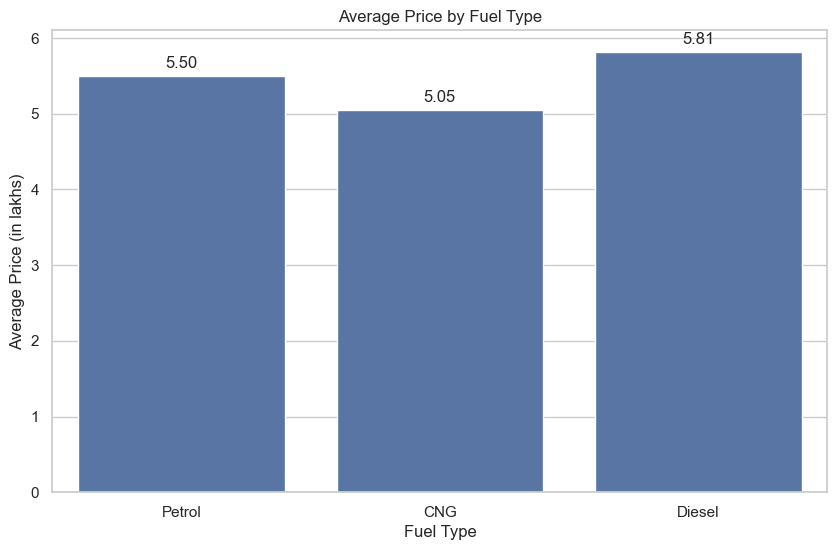

In [18]:
plt.figure(figsize=(10, 6))
bar_plot = sns.barplot(x='fuel_type', y='price', data=df_, errorbar=None)
for p in bar_plot.patches:
    bar_plot.annotate(format(p.get_height(), '.2f'),
                      (p.get_x() + p.get_width() / 2., p.get_height()),
                      ha = 'center', va = 'center',
                      xytext = (0, 9), textcoords = 'offset points')
plt.title('Average Price by Fuel Type')
plt.xlabel('Fuel Type')
plt.ylabel('Average Price (in lakhs)')
plt.show()

**Observation:**
- Manual Transmission Cars: The average price is around 5.28 lakhs
- Automatic Transmission Cars: The average price is approximately 6.56 lakh

**Analysis:**
- Automatic transmission cars are significantly more expensive on average compared to manual transmission cars

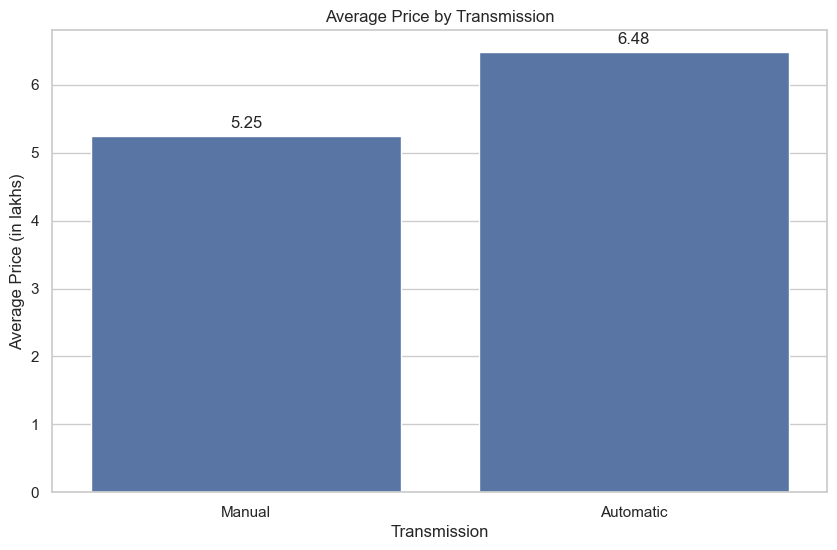

In [20]:
plt.figure(figsize=(10, 6))
bar_plot = sns.barplot(x='transmission', y='price', data=df_, errorbar=None)
for p in bar_plot.patches:
    bar_plot.annotate(format(p.get_height(), '.2f'),
                      (p.get_x() + p.get_width() / 2., p.get_height()),
                      ha = 'center', va = 'center',
                      xytext = (0, 9), textcoords = 'offset points')
plt.title('Average Price by Transmission')
plt.xlabel('Transmission')
plt.ylabel('Average Price (in lakhs)')
plt.show()

**Observation:**
- Manual Transmission Cars: A majority of the cars are from earlier years, with a notable concentration around 2016 and 2018
- Automatic Transmission Cars: There is a noticeable number of newer models, especially from 2018 onwards

**Analysis:**
- Manual transmission cars tend to be older models, while automatic transmission cars include a larger proportion of newer models

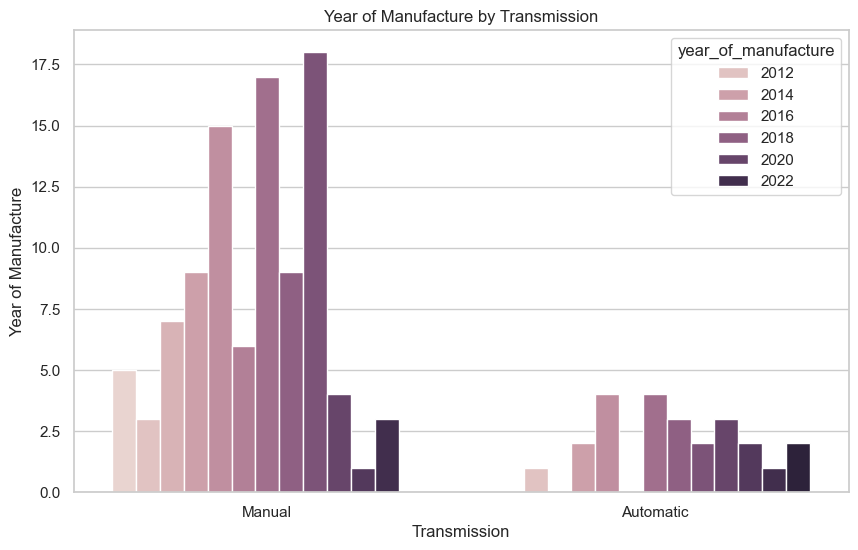

In [21]:
plt.figure(figsize=(10, 6))
count_plot = sns.countplot(x='transmission', data=df_, hue='year_of_manufacture')
plt.title('Year of Manufacture by Transmission')
plt.xlabel('Transmission')
plt.ylabel('Year of Manufacture')
plt.show()

 **1. Petrol Vehicles:**
- The majority of petrol vehicles were manufactured between 2012 and 2022
- The distribution shows a peak in the years 2014, 2016, and 2018
- There is a noticeable decline in the number of petrol vehicles manufactured after 2018

**Analysis:**
- The bulk of petrol vehicles were manufactured in 2014, 2016, and 2018, with these years showing the highest counts
- This suggests a higher production or registration of petrol vehicles during these years
- The decline after 2018 could indicate a shift in market preference or regulatory changes affecting petrol vehicle sales

**2. CNG Vehicles:**
- CNG vehicles have fewer entries overall
- The distribution shows a higher concentration of CNG vehicles manufactured around 2018
- There is minimal representation of CNG vehicles from other years

**Analysis:**
- The majority of CNG vehicles are concentrated around the year 2018, indicating a possible rise in popularity or incentives for CNG vehicles during this period
- The lower representation in other years suggests limited production or adoption of CNG vehicles overall

**3. Diesel Vehicles:**

- Similar to CNG, there are fewer diesel vehicles
- The distribution is more evenly spread out between the years 2014 and 2020, with a slight peak around 2020

**Analysis:**
- Diesel vehicles show a relatively even distribution between 2014 and 2020, with a slight increase around 2020
- This even spread suggests a steady but limited demand or production for diesel vehicles across these years

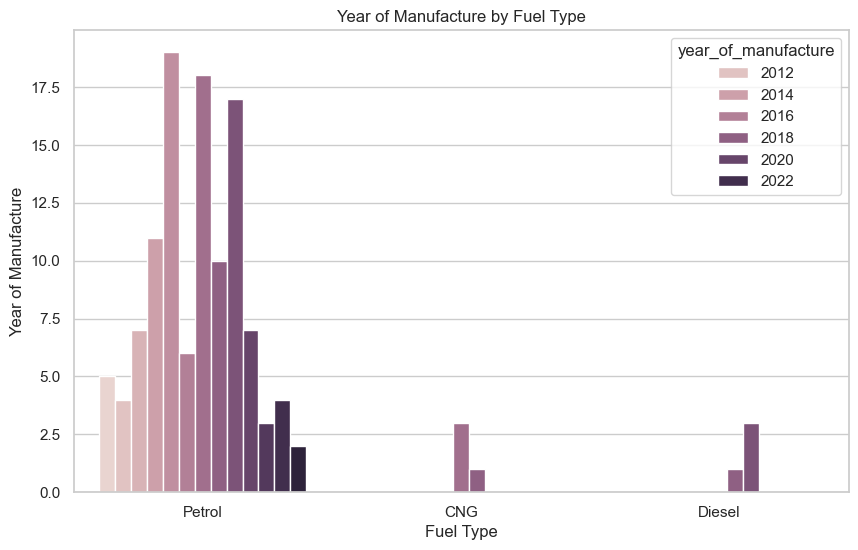

In [22]:
plt.figure(figsize=(10, 6))
count_plot = sns.countplot(x='fuel_type', data=df_, hue='year_of_manufacture')
plt.title('Year of Manufacture by Fuel Type')
plt.xlabel('Fuel Type')
plt.ylabel('Year of Manufacture')
plt.show()

**Observation:**
- The distribution of car prices peaks around 6 lakhs, with the majority of cars priced between 4 to 8 lakhs
- There are fewer cars in the lower price range (2-3 lakhs) and the higher price range (above 10 lakhs)
- The distribution shows a right skew, indicating that while most cars are moderately priced, there are a few high-priced cars that stretch the tail to the right

**Analysis:**
The price distribution is right-skewed, with the majority of vehicles priced between 4 to 8 lakhs, peaking at around 6 lakhs
- This indicates that most vehicles in the dataset are mid-range in terms of price, with relatively few high-end vehicles above 8 lakhs
- The long tail towards higher prices suggests that while expensive vehicles are less common, they are still present in the market

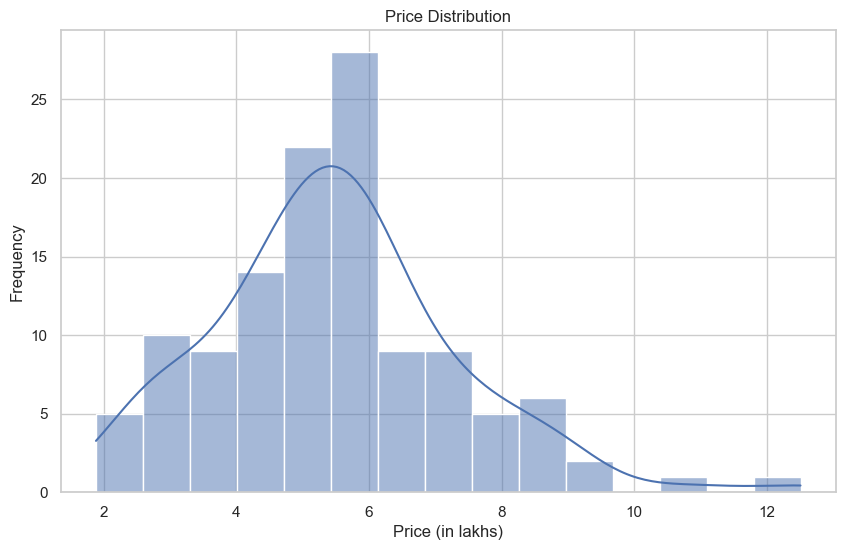

In [23]:
plt.figure(figsize=(10, 6))
sns.histplot(df_, x='price', bins=15, kde=True)
plt.title('Price Distribution')
plt.xlabel('Price (in lakhs)')
plt.ylabel('Frequency')
plt.show()

**Observation:**
- The kilometers driven distribution shows a peak around 40,000 kilometers
- Most vehicles have been driven between 20,000 and 80,000 kilometers
- There is a right skew in the distribution, with some vehicles having been driven up to 120,000 kilometers, but these are less common

**Analysis:**
- The distribution of kilometers driven shows a peak around 40,000 kilometers, with most vehicles having been driven between 20,000 and 80,000 kilometers
- The right-skewed distribution indicates that while higher mileage vehicles (up to 120,000 kilometers) exist, they are less common
- This suggests that the majority of vehicles in the dataset are moderately used, with relatively fewer vehicles having very high mileage

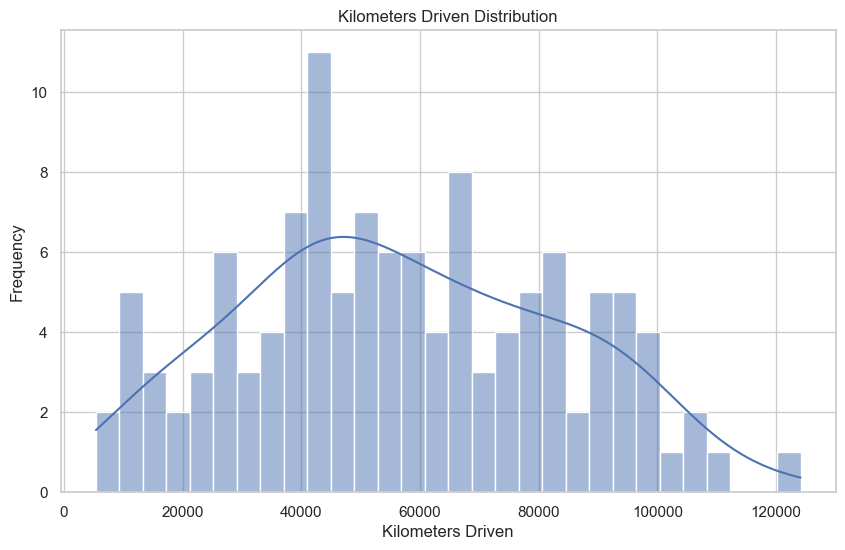

In [24]:
plt.figure(figsize=(10, 6))
sns.histplot(df_, x='kilometers_driven', bins=30, kde=True)
plt.title('Kilometers Driven Distribution')
plt.xlabel('Kilometers Driven')
plt.ylabel('Frequency')
plt.show()

**Observation:**
- The frequency of cars manufactured peaks around the years 2015, 2017, and 2019
- There is a noticeable decline in the number of cars manufactured in the more recent years (2020-2023)
- This could suggest that fewer cars from recent years are available in the dataset, possibly due to factors like lower production numbers, higher retention by original owners, or market dynamics affecting the resale of newer cars

**Analysis:**
- The year of manufacture and kilometers driven are significant factors in determining the price of a car, with newer and less-driven cars generally fetching higher prices

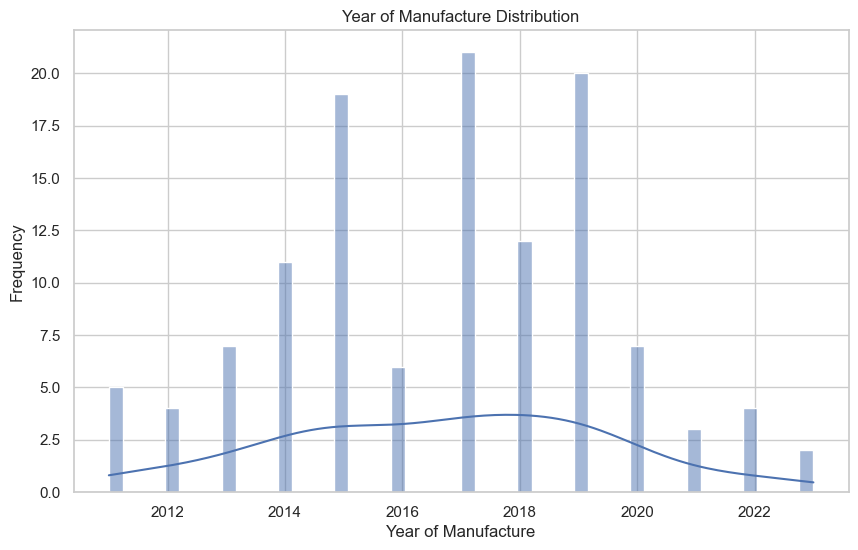

In [25]:
plt.figure(figsize=(10, 6))
sns.histplot(df_, x='year_of_manufacture', bins=50, kde=True)
plt.title('Year of Manufacture Distribution')
plt.xlabel('Year of Manufacture')
plt.ylabel('Frequency')
plt.show()

**Observation:**
- There is a general trend where cars with lower kilometers driven tend to have higher prices, which is expected as lower mileage often indicates better condition
- Despite the general trend, there is significant variability, with some cars having high prices despite high kilometers driven and vice versa
- This suggests other factors also play a significant role in determining price, such as brand, model, condition, and year of manufacture

**Analysis:**
- There is considerable variability in prices for a given year of manufacture or mileage, indicating that other factors, possibly including brand, model, and condition, also influence car prices

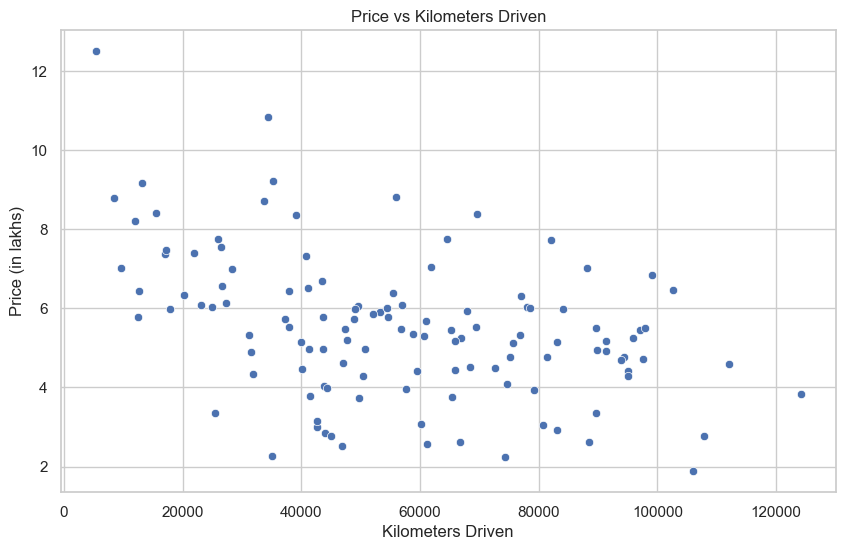

In [26]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='kilometers_driven', y='price', data=df_)
plt.title('Price vs Kilometers Driven')
plt.xlabel('Kilometers Driven')
plt.ylabel('Price (in lakhs)')
plt.show()

**Observation:**
- There is a clear positive correlation between the year of manufacture and the price of the car. Newer cars generally command higher prices
- The prices of cars from the year 2020 onwards show more variability, indicating a broader range of factors affecting the price in recent years
- Older cars (pre-2015) tend to cluster in the lower price range (2-4 lakhs), suggesting depreciation over time

**Analysis:**
- The market for cars manufactured in recent years (2020-2023) appears to be more dynamic with greater price variability, which may be due to newer car models having a wider range of features and conditions, or possibly economic factors influencing car values in recent times

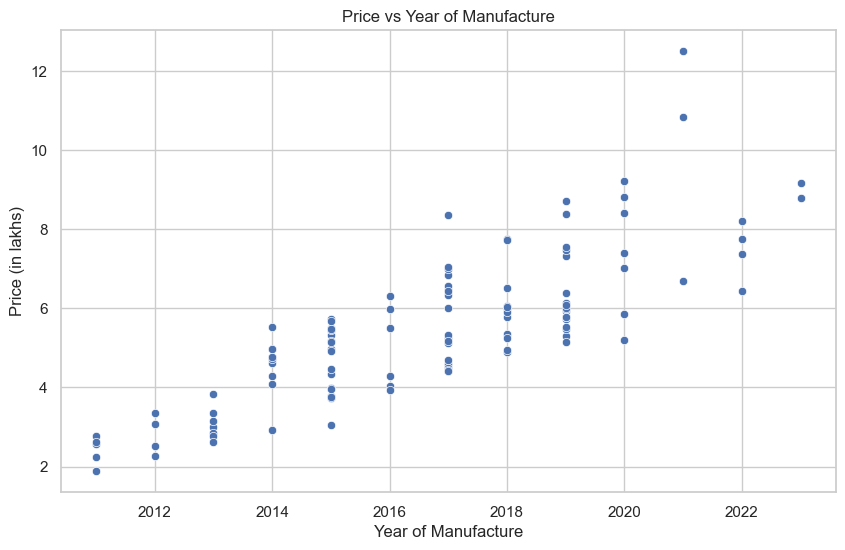

In [27]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='year_of_manufacture', y='price', data=df_)
plt.title('Price vs Year of Manufacture')
plt.xlabel('Year of Manufacture')
plt.ylabel('Price (in lakhs)')
plt.show()